# PCA-based EEG Artifact Removal

In this assignment, we'll generate synthetic multi-channel EEG data that includes alpha waves, blink artifacts, and muscle noise. You'll apply PCA (via SVD) to isolate and remove a blink-related component. Then you'll compare signals before and after cleaning using PSD and spectrogram analysis.

**Objectives**:
1. Generate realistic EEG-like data with random alpha activity, global blinks, and localized muscle artifacts.
2. Perform PCA (through SVD).
3. Detect the blink component more intelligently than simply removing the top PC.
4. Reconstruct signals without that component and observe improvements.
5. Estimate alpha peak frequency and amplitude before and after cleaning.

We split this assignment into several parts, each with tasks for partial credit.
Let's begin!

## Part 1: Setup and Imports

**Task**: Import the necessary libraries (NumPy, Matplotlib, `scipy.signal`) and set up basic parameters.
We'll define sampling rate, duration, number of channels, and so forth. We'll also create a directory for saving any plots if needed.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram

# STUDENT TODO:
# 1) Set random seed.
# 2) Define fs (int), duration (float), and n_channels (int).
# 3) Create time array t.
# 4) Optionally create a 'Figures' directory if you want to save plots.

np.random.seed(42)  # example
fs = 256
duration = 10.0  # we might later change this to 100.0
n_samples = int(fs * duration)
t = np.linspace(0, duration, n_samples)
n_channels = 8

os.makedirs('Figures', exist_ok=True)

print(f'Setup done: fs={fs}, duration={duration}, n_channels={n_channels}, n_samples={n_samples}')

Setup done: fs=256, duration=10.0, n_channels=8, n_samples=2560


## Part 2: Generate Synthetic EEG Data

Here, you'll simulate alpha waves plus blink and muscle artifacts.
1. Each channel has a random alpha frequency (8-12 Hz), amplitude (10-30), and random phase.
2. We add random noise.
3. Insert global blink artifacts (e.g., short triangular pulses).
4. Insert localized muscle artifacts in some channels.

**Tips**:
- Define a function or do it inline.
- Keep track of the final data shape = (n_channels, n_samples).
- You may want to store blink times for reference.

# Plan of Attack
Many of the numbers below require estimation, and we do so inline. Additionally, in view of part (e) below, we will scale the channels so that the first few channels are weighted more with regard to blinking than the last few. These channels correspond to the front sensors that are more sensitive to blinking.

In [3]:
# STUDENT TODO:
# 1) Create a data array of zeros, shape (n_channels, n_samples).
# 2) For each channel, generate alpha wave + noise.
# 3) Insert blink artifacts at random times.
# 4) Insert muscle bursts in a few channels.

data = np.zeros((n_channels, n_samples))

alpha_f_min, alpha_f_max = 8.0, 12.0
noise_level = 5.0

# Example partial solution (you can refine):
counter = 1
for ch in range(n_channels):
    f_alpha = np.random.uniform(alpha_f_min, alpha_f_max)
    
    # These values are likely given in microvolts
    alpha_amp = np.random.uniform(10.0, 30.0)
    
    print("Channel " + str(counter) + " - Frequency: " + str(f_alpha) + " and Amplitude: " + str(alpha_amp))
    counter += 1
    alpha_phase = np.random.uniform(0, 2*np.pi) 
    alpha_wave = alpha_amp * np.sin(2*np.pi*f_alpha * t + alpha_phase)
    noise = np.random.normal(0, noise_level, n_samples)
    data[ch] = alpha_wave + noise

# These are some values that I have estimated
num_blinks = 6 # number of blinks in a 10 second period
blink_width = 0.025 # human blink lasts about 0.25 second
blink_amp_base = 100 # microvolts
channel_scaling = np.linspace(1.5, 0.5, n_channels) # In view of part (e) below, we'll weight the first few channels (front channels) heavier

num_muscle = int(0.25 * n_channels) # 25% of the channels sense muscle artifacts
burst_duration = 0.1 # length of muscle twitch
muscle_amp_base = 250 # microvolts

# Insert blink artifacts

blink_times = np.sort(np.random.uniform(1.0, duration - 1.0, num_blinks))
for bt in blink_times:
    center_idx = int(bt * fs)
    half_w = int(blink_width * fs / 2)
    for i in range(center_idx - half_w, center_idx + half_w):
        if 0 <= i < n_samples:
            dist = abs(i - center_idx)
            shape_amp = 1.0 - dist / half_w
            if shape_amp < 0.0:
                shape_amp = 0.0
            for ch in range(n_channels):
                data[ch, i] += blink_amp_base * channel_scaling[ch] * shape_amp

# Insert muscle artifacts
chosen_channels = np.random.choice(n_channels, size=num_muscle, replace=False)
for ch in chosen_channels:
    burst_time = np.random.uniform(1.0, duration - 1.0)
    burst_start = int(burst_time * fs)
    burst_len = int(burst_duration * fs)

    muscle_freq = np.random.uniform(20, 50)
    muscle_phase = np.random.uniform(0, 2*np.pi)
    for i in range(burst_len):
        idx = burst_start + i
        if 0 <= idx < n_samples:
            data[ch, idx] += muscle_amp_base * np.sin(2*np.pi*muscle_freq * t[idx] + muscle_phase)

print(f'Generated data shape: {data.shape}')

Channel 1 - Frequency: 9.49816047538945 and Amplitude: 29.01428612819832
Channel 2 - Frequency: 8.266258911656891 and Amplitude: 22.96636014904191
Channel 3 - Frequency: 8.57774593662031 and Amplitude: 18.8413242623615
Channel 4 - Frequency: 11.980637640800484 and Amplitude: 17.98218599114852
Channel 5 - Frequency: 10.195754714074699 and Amplitude: 10.070217018213013
Channel 6 - Frequency: 11.373929971257143 and Amplitude: 17.224454704685726
Channel 7 - Frequency: 10.75764683372205 and Amplitude: 21.96505861034104
Channel 8 - Frequency: 8.295686866583054 and Amplitude: 18.142739877545544
Generated data shape: (8, 2560)


## Part 3: Inspect Raw Signals

Plot the raw signals in a single figure, offsetting each channel so we can see them distinctly.
**Task**:
- Make a time-domain plot of all channels.
- Label axes, title.

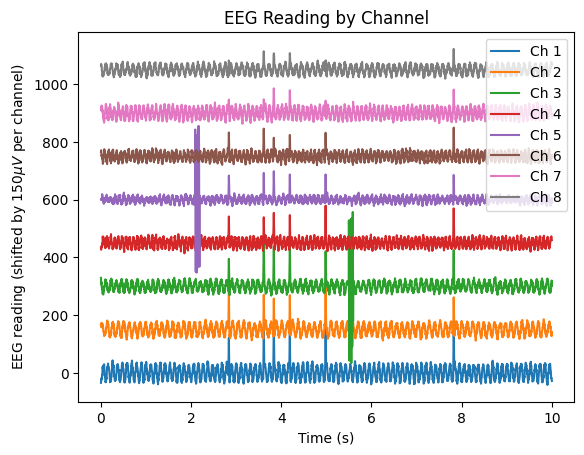

In [5]:
# STUDENT TODO:
# Plot the data. Add offsets to each trace to make it visible. Label the axis and ticks appropriately
offset = 150

for ch in range(n_channels):
    plt.plot(t, data[ch] + ch*offset, label=f'Ch {ch+1}')

plt.xlabel("Time (s)")
plt.ylabel(r"EEG reading (shifted by 150$\mu V$ per channel)")
plt.title("EEG Reading by Channel")
plt.legend()
plt.show()

# Observations
We notice that in additionto the 6 blinks described above, there are also two larger muscle artifacts. The objective of this project will be to detect and mitigate the effect of the blinks so that we can more accurately assess the alpha waves.

## Part 4: SVD-based PCA

We'll center the data, do an SVD, and interpret the singular values. Then we'll define a function to get principal components in the time domain.
**Tasks**:
1. Subtract each channel's mean.
2. Apply `np.linalg.svd`.
3. Plot singular values.
4. Write a function to produce PC time series = S diag * Vt.

Singular values: [1428.57183562 1115.06566076 1019.54299329 1005.11055947  846.2972522
  755.60235018  670.9350015   511.25758447]


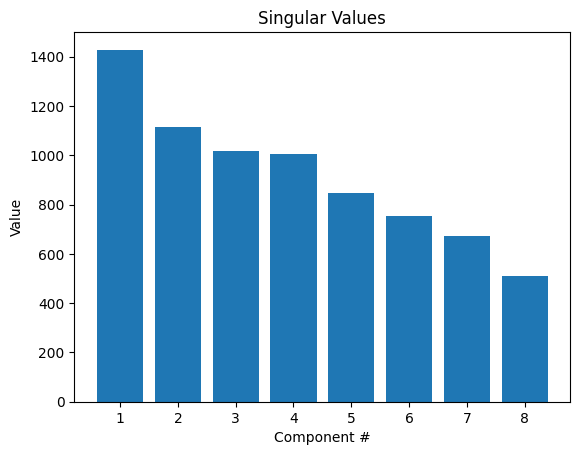

PC time series shape: (8, 2560)


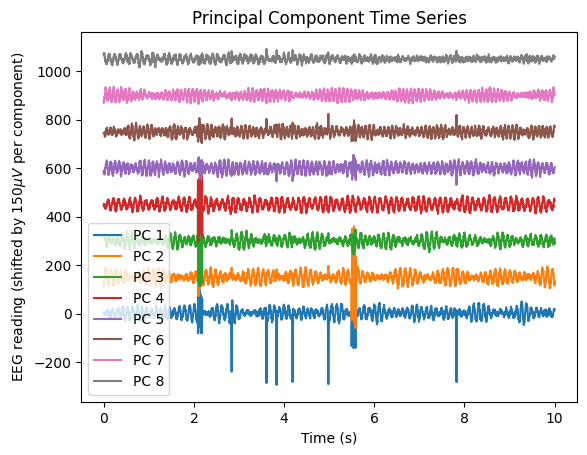

In [7]:
# STUDENT TODO:
mean_subtracted = np.zeros((n_channels, n_samples))

for ch in range(n_channels):
    mean_subtracted[ch] = data[ch] - np.mean(data[ch])

U, S, Vt = np.linalg.svd(mean_subtracted)

print('Singular values:', S)
# Plot them
plt.figure()
plt.bar(range(1, len(S)+1), S)
plt.title('Singular Values')
plt.xlabel('Component #')
plt.ylabel('Value')
plt.show()

def get_pc_time_series(U, S, Vt):
    S_diag = np.diag(S)
    # Multiply the diagonal S matrix by the first n_channel rows of Vt, which represent the major temporal patterns in the data (recall that the 
    # right singular vectors in SVD belong in the matrix V, with the vectors in the first few columns corresponding to the vectors of greatest singular
    # value. Thus the vectors in the first few rows of Vt correspond to the vectors of greatest singular value.
    return np.dot(S_diag, Vt[:n_channels,:])

pc_time = get_pc_time_series(U, S, Vt)
print(f'PC time series shape: {pc_time.shape}')

# Let's also plot the principal component time series
for pc in range(8):
    plt.plot(t, pc_time[pc] + pc*offset, label=f'PC {pc+1}')

plt.xlabel("Time (s)")
plt.ylabel(r"EEG reading (shifted by 150$\mu V$ per component)")
plt.title("Principal Component Time Series")
plt.legend()
plt.show()

# Observations
We notice above that the first few principal components exhibit more drastic behaviors, while the less significant principal components are relatively calm. In particular, by comparing the first principal component above (in blue) with the EEG reading by channel, we notice that it corresponds quite well, which indicates that the first principal component may be linked to blinking. The second, third, and fourth principal components seem to be linked to muscle artifacts, although we do not investigate this in this project.

## Part 5: Detect & Remove Blink Component

**Tasks**:
1. Write a function to identify the blink PC by looking at the top 3 singular values and the ratio of front vs. back channels in U.
2. Set that singular value to 0, reconstruct the data.
3. Plot the cleaned signals in time.

# Plan of Attack
I order to identify the blink principal component, we will consider the top 3 singular values, but we also consider the spatial data 
given in U. The first 4 channels represent the front channels, and the remaining channels represent the back channels. Blinks are typically
associated with front channels, and so singular values that have high components in channels 1-4 are more likely to represent the blinks.
Thus we weigh the singular values by a certain as shown below.

Detected blink component: 0


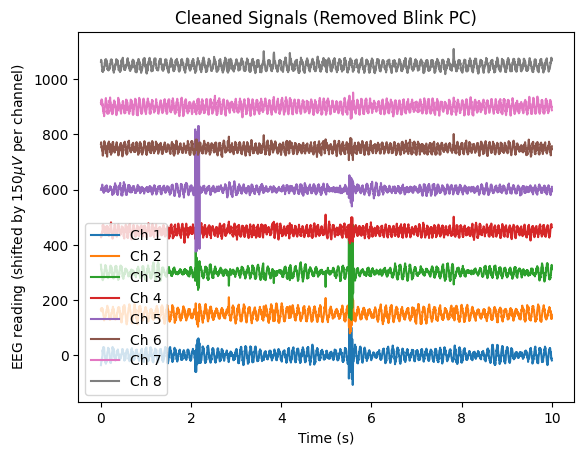

In [9]:
# STUDENT TODO:
# Example:
def detect_blink_component(U, S):
    # We will consider the top 3 singular values, but we also consider the spatial data given in U.
    top_singular_values = S[:3]
    
    front_channels = U[:4, :3]  
    back_channels = U[4:, :3]
    
    front_contribution = np.sum(np.abs(front_channels), axis=0)
    back_contribution = np.sum(np.abs(back_channels), axis=0) 
    
    # Compute the front-to-back ratio for each component, scaled by the singular value
    front_ratio = front_contribution / (front_contribution + back_contribution)    
    weighted_front_ratio = front_ratio * top_singular_values
    
    blink_idx = np.argmax(weighted_front_ratio)
    
    return blink_idx

blink_comp_idx = detect_blink_component(U, S)

print(f'Detected blink component: {blink_comp_idx}')
    
def reconstruct_data(U, S, Vt, remove_list):
    # Create a modified version of the singular values to avoid modifying the original
    S_mod = S.copy()
    S_mod[remove_list[0]] = 0

    # Create the modified Sigma matrix with correct dimensions
    # We need a diagonal matrix with size (8, 2560) in order for U * S * Vt to work out
    Sigma_mod = np.zeros((U.shape[0], Vt.shape[0]))

    # Fill the diagonal of the matrix to return with the matrix of singular values (with the blink value set to 0)
    np.fill_diagonal(Sigma_mod, S_mod)
    
    return U @ Sigma_mod @ Vt

clean_centered = reconstruct_data(U, S, Vt, [blink_comp_idx])
clean_data = clean_centered + np.mean(data)

# Plot the cleaned signals with offsets

for ch in range(n_channels):
    plt.plot(t, clean_data[ch] + ch*offset, label=f'Ch {ch+1}')
plt.title('Cleaned Signals (Removed Blink PC)')
plt.xlabel("Time (s)")
plt.ylabel(r"EEG reading (shifted by 150$\mu V$ per channel)")
plt.legend()
plt.show()

# Observations
We notice immediately that most of the artifcats caused by blinking have been removed: what remains are the muscle artifacts. This means that indeed, the first principal component was the causer of the sporadic spikes in the EEG readings, and we have successfully removed the brunt of this effect.

## Part 6: PSD & Spectrogram + Alpha Wave Parameter

**Tasks**:
1. Compute & plot PSD (via `welch`) for raw vs. cleaned signals.
2. Compute & plot spectrogram on at least one channel.
3. Estimate alpha frequency/amplitude (peak in 8-12 Hz) before & after cleaning,
   and print the results.

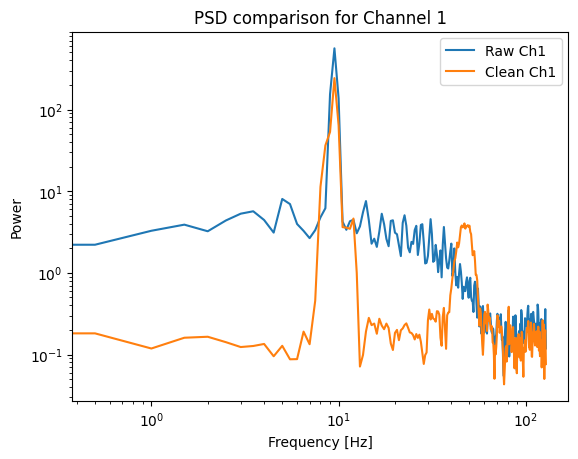

In [11]:
# STUDENT TODO: partial code example
# PSD overlay
f_raw, p_raw = welch(data[0], fs=fs, nperseg=2*fs)
f_cln, p_cln = welch(clean_data[0], fs=fs, nperseg=2*fs)
plt.figure()
plt.plot(f_raw, p_raw, label='Raw Ch1')
plt.plot(f_cln, p_cln, label='Clean Ch1')
plt.xscale('log'); plt.yscale('log')
plt.title('PSD comparison for Channel 1')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.show()

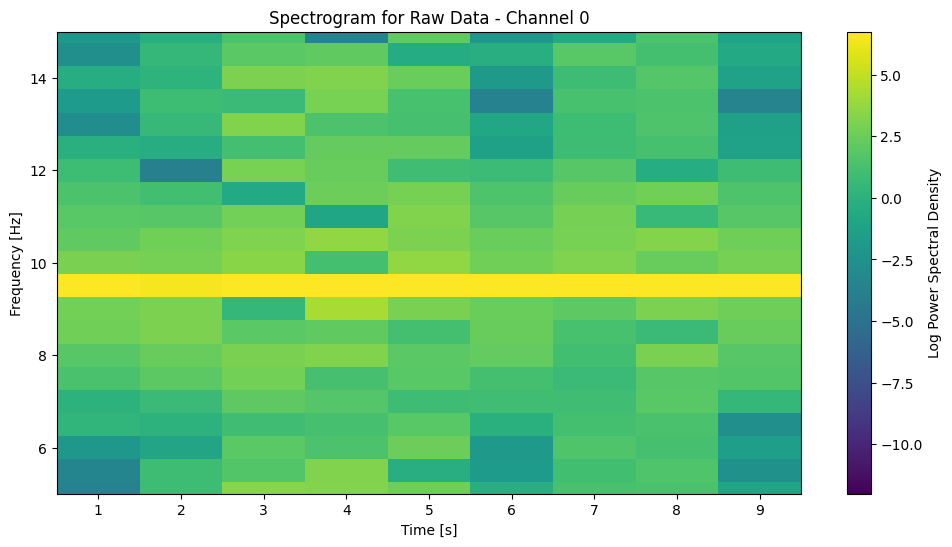

In [13]:
# Now, we plot the spectrogram of channel 1
f_sp, t_sp, Sxx_raw = spectrogram(data[0], fs=fs, nperseg=512, noverlap=256)
plt.figure(figsize=(12,6))
plt.pcolormesh(t_sp, f_sp, np.log(Sxx_raw))
plt.title('Spectrogram for Raw Data - Channel 0')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Log Power Spectral Density')
plt.ylim([5, 15])  # We focus on the frequency range of 8-12 Hz
plt.show()

In [15]:
# define a function to find alpha peak freq & amplitude.
def find_alpha_peak(f, p, alpha_band=(8, 12)):

    alpha_range = (f >= alpha_band[0]) & (f <= alpha_band[1])
    
    f_alpha = f[alpha_range]
    p_alpha = p[alpha_range]
    
    # Find the peak frequency and corresponding amplitude
    peak_idx = np.argmax(p_alpha)
    peak_freq = f_alpha[peak_idx]
    peak_amp = p_alpha[peak_idx]
    
    return peak_freq, peak_amp
    
# Then do it on each channel raw vs. cleaned, print results.
print("Frequency of alpha wave in channel 1 (raw) is " + str(find_alpha_peak(f_raw, p_raw)[0]) + " and amplitude of PSD is " + str(find_alpha_peak(f_raw,p_raw)[1]))
print("Frequency of alpha wave in channel 1 (cleaned) is " + str(find_alpha_peak(f_cln, p_cln)[0]) + " and amplitude of PSD is " + str(find_alpha_peak(f_cln,p_cln)[1]))


Frequency of alpha wave in channel 1 (raw) is 9.5 and amplitude of PSD is 561.9785422509389
Frequency of alpha wave in channel 1 (cleaned) is 9.5 and amplitude of PSD is 242.4326520373687


# Observations
Looking back at part (b), we notice that the frequency of the wave injected in channel 1 had a frequency of 9.498 Hz, which is extremely close to the 9.5 Hz seen here. Admittedly, the calculation of $f_{raw}$ only allows for frequency resolution of 1 Hz, so we were a little bit lucky. Nevertheless, we see that the estimated frequency of the PSD is essentially correct. Here, we have printed the amplitudes of the power spectral density of the alpha wave, and we notice that the PSD peak of the cleaned results is markedly lower than that of the results containing the blinks. The amplitude of the actual alpha wave is proportional to the square root of the PSD, but there is a scaling factor. I have not done it here, but it is certainly possible to estimate the amplitude of the alpha wave (which in the given scenario is 10-30, and in the case of channel 1, it is 29.014) using methods analogous to those presented in project 2 (convolving the signal with the now known frequency).

Another important observation is that the PSD for the cleaned data is a lot less noisy, in the sense that for the irrelevant frequencies, the PSD is an order of magnitude or so (except for one spike near 50 Hz) lower than the raw data. This increases our confidence in the correctness of the alpha wave frequency, as the signal-to-noise ratio is higher.